# Rangelands dynamics with Sentinel-1

This notebook gives an example of using Sentinel-1 analysis ready data (ARD) radar backscatter (Gamma nought) and dual-polarimetric decomposition (Alpha, Entropy and Anisotropy) for exploring annual rangeland dynamics.

Sentinel-1 (in this case it is the dual-pol Radar Vegetation Index (RVI) and Entropy bands) and Sentinel-2 NDVI are compared for multi-temporal trends - due to their relationships with vegetation biomass. A grasslands mask is then applied, before the monthly means are generated for the RVI and Entropy bands. These monthly means as well as the annual range in RVI and Entropy are output as GeoTIFF files.

The following steps are used:
1.  Load Sentinel-1 radar backscatter data through the datacube API
2.  Apply speckle filtering
3.  Calculate dual-pol Radar Vegetation Index (RVI)
4.  Load Sentinel-1 dual-pol decomposition data
5.  Load Sentinel-2 data and calculate NDVI
6.  Interactively compare RVI, Entropy and NDVI time series
7.  Show annual statistics
8.  Apply grasslands mask to area
9.  Generate monthly means for RVI and Entropy
10.  Save results to GeoTIFF files

This notebook was written using the Virtual Desktop Infrastructure (VDI) on the National Computational Infrastructure (NCI), allowing access to the current Sentinel-1 and Digitial Earth Australia (DEA) ARD datasets. For this notebook to work you must first load the relevant modules:
-  module use /g/data/v10/public/modules/modulefiles
-  module load dea

The Sentinel-1 data are indexed as product 'S1_gamma0_scene_v2' for radar backscatter and 's1_haalpha_scene' for dual-pol decomposition.

# 1. Load Sentinel-1 radar backscatter data through the datacube API

Area of interest is in the Fitzroy Catchment of Western Australia

In [1]:
%pylab notebook
import datacube
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
dc = datacube.Datacube(config='radar.conf')

In [3]:
# Currently need to use 2017 for a complete year of data

Year = '2017'

query = {
# Fitzroy floodplain
'y': (-18.6, -18.4),
'x': (125.0, 125.2),
    
'time': (Year + '-01-01', Year + '-12-31'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (25, -25)
}

In [4]:
bs=dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', **query)

In [5]:
# Remove scenes that are mostly nulls
# Uses code from https://github.com/fangfy/dea-projects/blob/master/water_interoperability/sentinel1_load_and_classify_nci.ipynb

total_px=len(bs.x)*len(bs.y)
valid=bs.where(bs.vv!=0).where(bs.vh!=0).count(dim=('x','y'))
good=(valid.vh/total_px)>0.5
bs_good = bs.sel(time=good)

# 2. Apply speckle filtering
Uses code from https://github.com/fangfy/dea-projects/blob/master/water_interoperability/sentinel1_load_and_classify_nci.ipynb

In [6]:
# Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [7]:
# Apply speckle filter

# replace nan with 0
bs_good_zerofilled = bs_good.where(~bs_good.isnull(), 0)

smoothed_vv=bs_good_zerofilled.vv.groupby('time').apply(lee_filter, size=7)
smoothed_vh=bs_good_zerofilled.vh.groupby('time').apply(lee_filter, size=7)

In [8]:
# Create smoothed dataset with Nans and assign attributes

# save the nodata mask
nodata_mask = bs_good.isnull().to_array().any(axis=0)

smoothed=smoothed_vv.to_dataset(name='vv')
smoothed['vh']=smoothed_vh
smoothed=smoothed.where(~nodata_mask)

# Remove unused data
bs_attrs = bs.attrs
smoothed = smoothed.assign_attrs(bs_attrs)

del bs, bs_good
smoothed

<xarray.Dataset>
Dimensions:  (time: 29, x: 891, y: 932)
Coordinates:
  * y        (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x        (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
  * time     (time) datetime64[ns] 2017-01-06T21:06:37.067738 ... 2017-12-20T21:06:46.267397
Data variables:
    vv       (time, y, x) float32 0.058082025 0.06558088 ... 0.08221259
    vh       (time, y, x) float32 0.019151364 0.023157777 ... 0.021565245
Attributes:
    crs:      EPSG: 3577

<IPython.core.display.Javascript object>


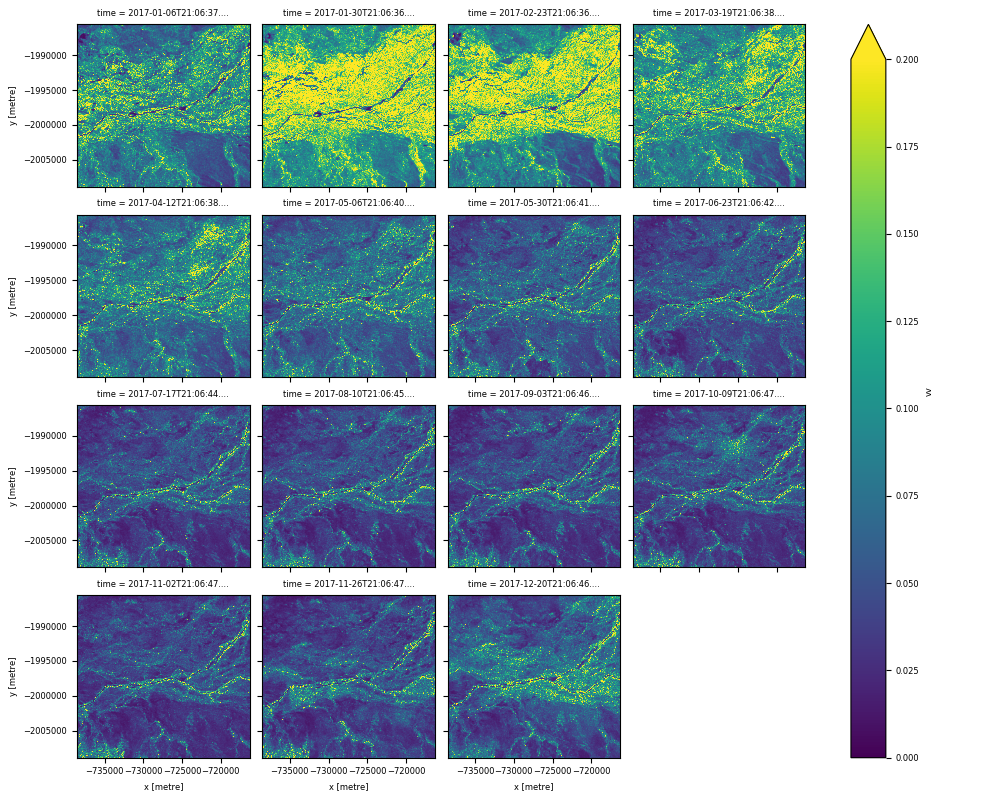

In [9]:
# View smoothed VV backscatter data
pylab.rcParams['font.size']=6

ntimes=len(smoothed.time.values)
smoothed.vv.isel(time=slice(0,ntimes,2)).plot(col='time',col_wrap=4, vmin=0, vmax=0.2, figsize=(10,8))

# 3. Calculate dual-pol Radar Vegetation Index (RVI)

In [10]:
smoothed['RVI'] = 4*smoothed.vh/(smoothed.vv + smoothed.vh)

<IPython.core.display.Javascript object>


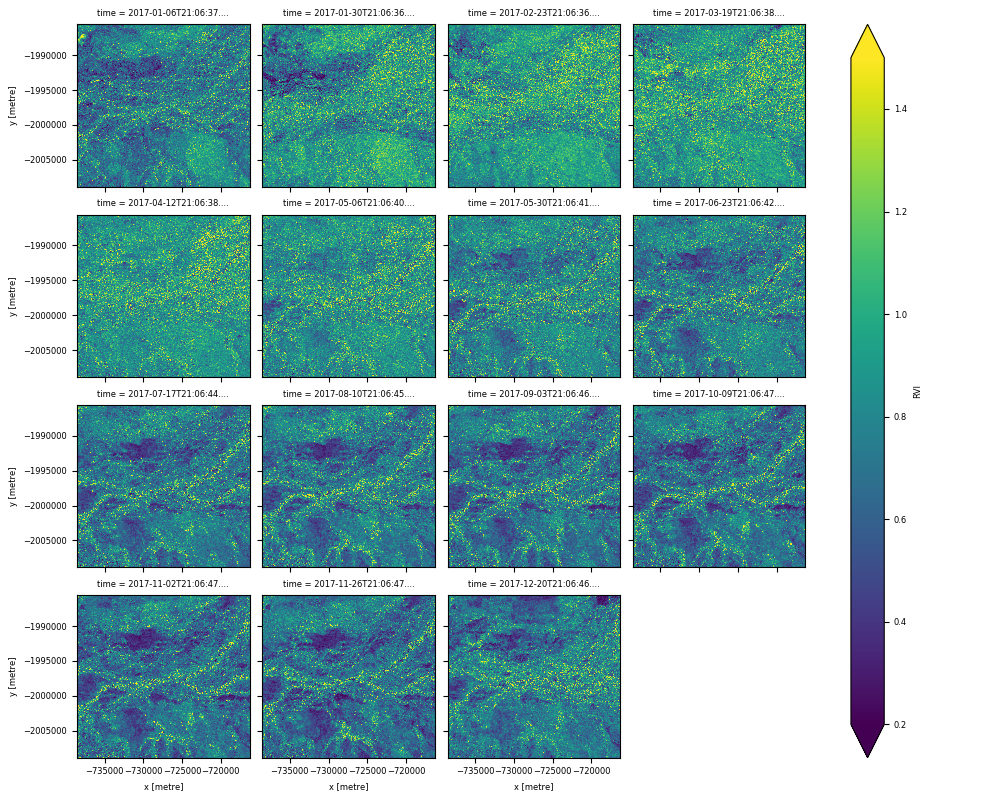

In [11]:
# View RVI data

ntimes=len(smoothed.time.values)
smoothed.RVI.isel(time=slice(0,ntimes,2)).plot(col='time',col_wrap=4, vmin=0.2, vmax=1.5, figsize=(10,8))

# 4. Load Sentinel-1 dual-pol decomposition data

In [12]:
dp=dc.load(product='s1_haalpha_scene', group_by='solar_day', **query)

In [13]:
# Remove any '0' values
dp = dp.where(dp.entropy!=0)
dp

<xarray.Dataset>
Dimensions:     (time: 59, x: 891, y: 932)
Coordinates:
  * time        (time) datetime64[ns] 2017-01-06T21:06:37.194455 ... 2017-12-25T21:14:51.529181
  * y           (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x           (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
Data variables:
    entropy     (time, y, x) float32 0.82229125 0.7376541 ... 0.85633445
    anisotropy  (time, y, x) float32 0.4847056 0.583905 ... 0.43876868
    alpha       (time, y, x) float32 58.153442 64.67583 ... 67.36098 59.55295
Attributes:
    crs:      EPSG: 3577

<IPython.core.display.Javascript object>


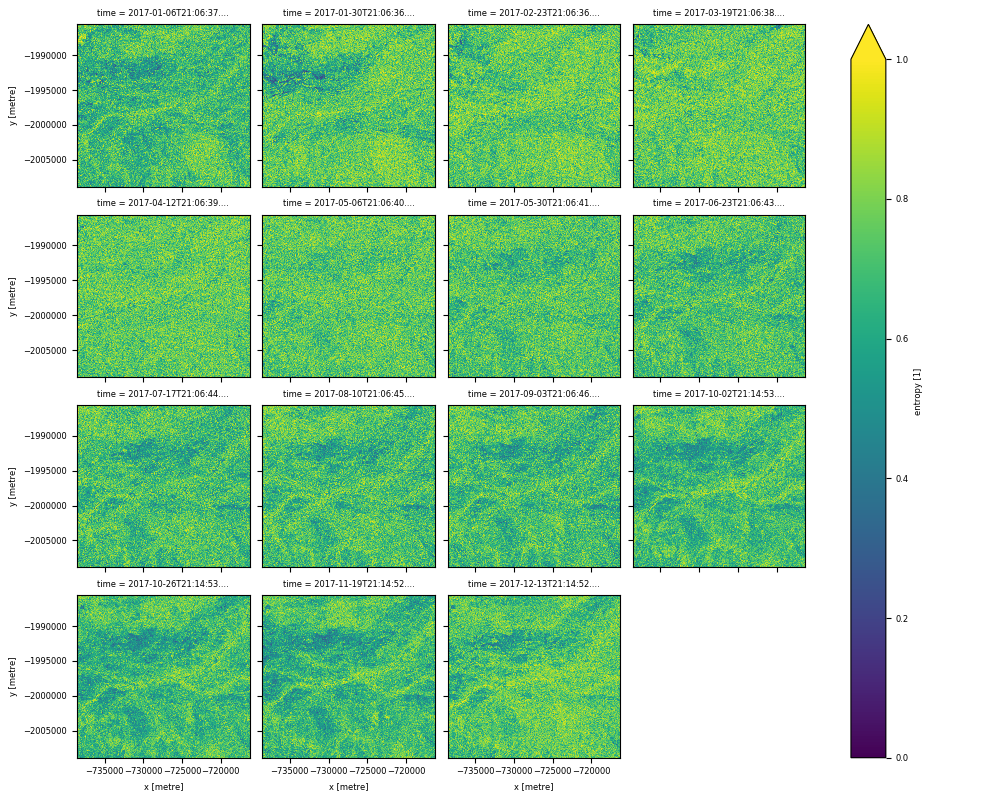

In [14]:
# View entropy data  
ntimes=len(dp.time.values)
dp.entropy.isel(time=slice(0,ntimes,4)).plot(col='time',col_wrap=4, vmin=0, vmax=1.0, figsize=(10,8))

# 5. Load Sentinel-2 data and calculate NDVI

In [15]:
dc_S2 = datacube.Datacube(app='dc-S2-extract')

In [16]:
# Read S2 green, nir and cloud mask bands for S2a and S2b
bands_of_interest = ['nbar_green', 'nbar_nir_2', 'fmask']
sensors = ['s2a','s2b']

s2 = {}
for sensor in sensors:
    s2[sensor] = dc_S2.load(product = sensor+'_ard_granule', group_by='solar_day', measurements = bands_of_interest, **query)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series

In [17]:
# Combine the S2a and S2b dates
import xarray as xr
s2_clean = xr.concat(s2.values(), dim='time')

# Remove clouds and nulls from S2 data
nbar_green = s2_clean.nbar_green
s2_good=nbar_green.to_dataset(name='green')
s2_good['nir']=s2_clean.nbar_nir_2
s2_good['fmask']=s2_clean.fmask

s2_good_temp = s2_good.where(s2_good.fmask<2) # to remove cloud/shadow/nulls based on fmask
s2_good_clean = s2_good_temp.where(s2_good_temp.fmask!=0)

s2_good_clean = s2_good_clean.assign_attrs(bs_attrs)

del s2, s2_good
s2_good_clean

<xarray.Dataset>
Dimensions:  (time: 61, x: 891, y: 932)
Coordinates:
  * y        (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x        (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
  * time     (time) datetime64[ns] 2017-01-01T01:56:12.026000 ... 2017-12-29T01:46:49.027000
Data variables:
    green    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    nir      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    fmask    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG: 3577

In [18]:
# Create NDVI band
s2_good_clean['ndvi']=(s2_good_clean.nir.astype(float) - s2_good_clean.green.astype(float))/(s2_good_clean.nir.astype(float) + s2_good_clean.green.astype(float))

# Remove dates containing mostly nulls
total_px=len(s2_good_clean.ndvi.x)*len(s2_good_clean.ndvi.y)
valid=s2_good_clean.where(~s2_good_clean.ndvi.isnull()).count(dim=('x','y'))
s2_mostly_good=(valid.ndvi/total_px)>0.5
s2_good_clean = s2_good_clean.sel(time=s2_mostly_good)

# Remove any remaining erroneous values (where NDVI <-1.0 and NDVI > 1.0)
s2_good_clean = s2_good_clean.where(s2_good_clean.ndvi > -1.0).where(s2_good_clean.ndvi < 1.0)

<IPython.core.display.Javascript object>


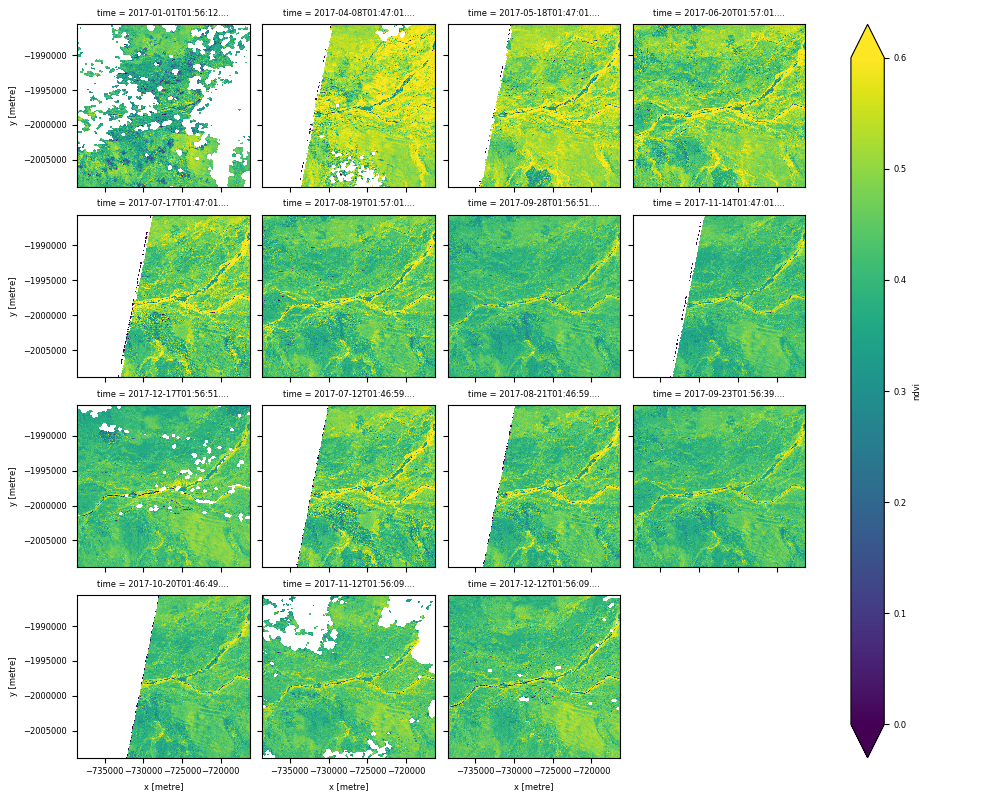

In [19]:
# View S2 NDVI time series
ntimes=len(s2_good_clean.time.values)
s2_good_clean.isel(time=slice(0,ntimes,3)).ndvi.plot(col='time', col_wrap=4, vmin=0.0, vmax=0.6, figsize=(10,8))

# 6. Interactively compare RVI, Entropy and NDVI time series

In [20]:
def onclick(event):
    global pixelx, pixely
    x, y = int(event.xdata), int(event.ydata)
    image_coords = smoothed.affine * (x, y)
    pixelx = x 
    pixely = y 
    w.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely)

Click on the pixel to view its time series below


<IPython.core.display.Javascript object>


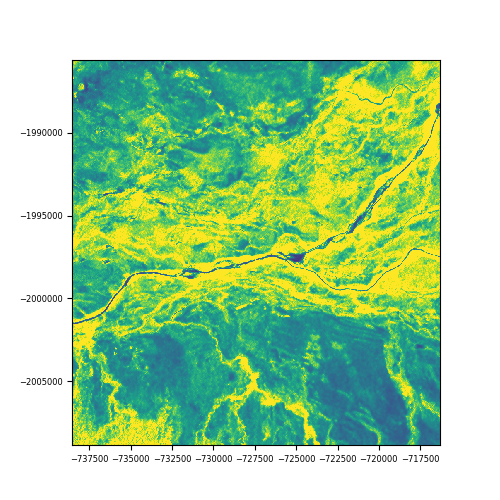

HTML(value='Click on the pixel to view its time series below')

In [21]:
import ipywidgets as widgets

print('\033[1m' + 'Click on the pixel to view its time series below' + '\033[0m')

fig = plt.figure(figsize = (5,5))
plt.imshow(np.flip(smoothed.vv.mean(dim='time')), interpolation = 'nearest', clim=(0,0.1), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()]) 

w = widgets.HTML("Click on the pixel to view its time series below")

cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


<IPython.core.display.Javascript object>


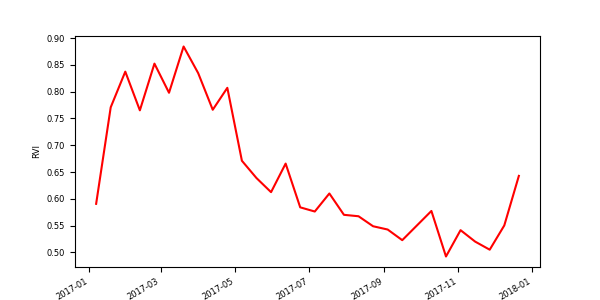

<IPython.core.display.Javascript object>


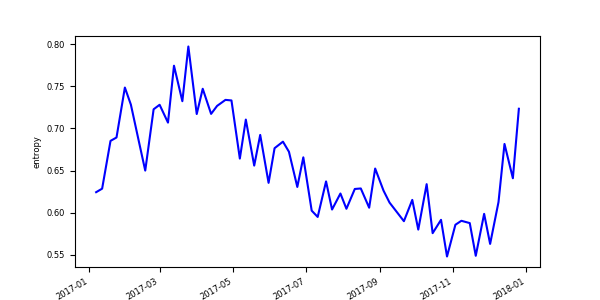

<IPython.core.display.Javascript object>


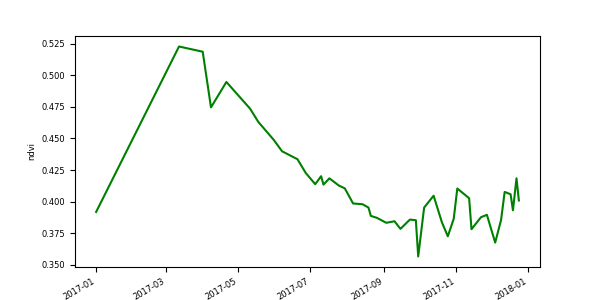

('for point :', slice(-729963, -730163, None), slice(-2004681, -2004481, None))

In [22]:
# plot RVI, Entropy and NDVI through time based on the x,y point selected
#from matplotlib import pyplot as plt

# expand selected x,y pixel to make a square area of interest
xp, yp=slice(pixelx+100,pixelx-100), slice(pixely-100,pixely+100)

(smoothed.sel(x=xp,y=yp).RVI.groupby('time').mean()).plot(color='r', figsize=(6,3))
(dp.sel(x=xp,y=yp).entropy.groupby('time').mean()).plot(color='b', figsize=(6,3))
(s2_good_clean.sel(x=xp,y=yp).ndvi.groupby('time').mean()).plot(color='g', figsize=(6,3))
'for point :', xp, yp

# 7. Show Annual Statistics

<IPython.core.display.Javascript object>


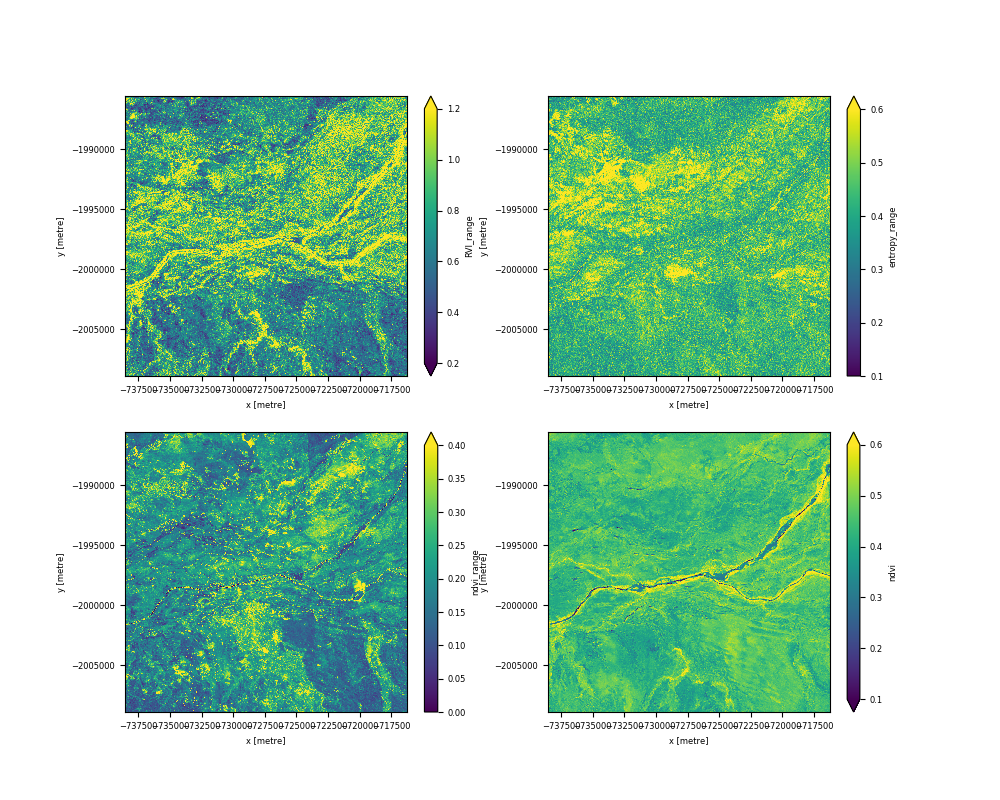

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [23]:
# Calculate annual range (max minus min) for radar backscatter RVI, dul-pol decomposition Entropy, and NDVI
from matplotlib import pyplot as plt

smoothed['RVI_range'] = smoothed.RVI.max(dim='time') - smoothed.RVI.min(dim='time')
dp['entropy_range'] = dp.entropy.max(dim='time') - dp.entropy.min(dim='time')
s2_good_clean['ndvi_range'] = s2_good_clean.ndvi.max(dim='time') - s2_good_clean.ndvi.min(dim='time')

fig, ax = plt.subplots(2,2, figsize=(10,8))
smoothed.RVI_range.plot(vmin=0.2,vmax=1.2, ax = ax[0,0])
dp.entropy_range.plot(vmin=0.1,vmax=0.6, ax = ax[0,1])
s2_good_clean.ndvi_range.plot(vmin=0.0,vmax=0.4, ax = ax[1,0])
s2_good_clean.ndvi.mean(dim='time').plot(vmin=0.1,vmax=0.6, ax = ax[1,1])

<IPython.core.display.Javascript object>


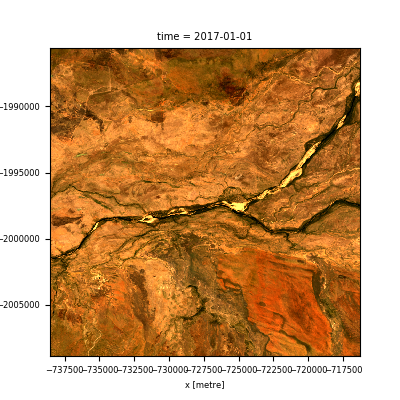

In [24]:
# View same area/year of a true colour Landsat image (annual median value)
LS = dc_S2.load(product = 'ls8_nbart_geomedian_annual', **query)
LS[['red','green','blue']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(4,4))

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<IPython.core.display.Javascript object>


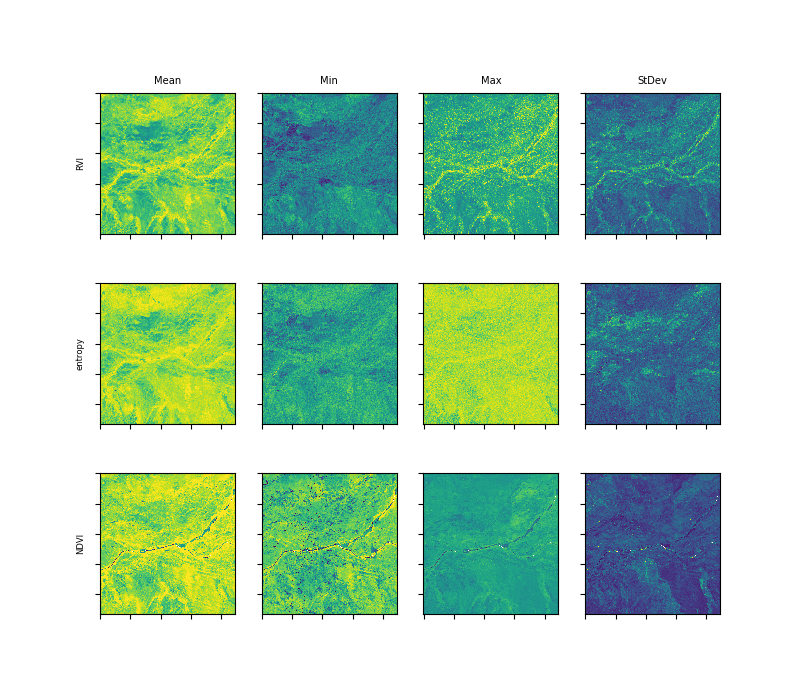

[]

In [25]:
# Show RVI, Entropy and NDVI mean, min, max and stand deviation for current year

RVI_mean = np.flip(smoothed.RVI.mean(dim='time'))
RVI_min = np.flip(smoothed.RVI.min(dim='time'))
RVI_max = np.flip(smoothed.RVI.max(dim='time'))
RVI_std = np.flip(smoothed.RVI.std(dim='time'))

entropy_mean = np.flip(dp.entropy.mean(dim='time'))
entropy_min = np.flip(dp.entropy.min(dim='time'))
entropy_max = np.flip(dp.entropy.max(dim='time'))
entropy_std = np.flip(dp.entropy.std(dim='time'))

NDVI_mean = np.flip(s2_good_clean.ndvi.mean(dim='time'))
NDVI_min = np.flip(s2_good_clean.ndvi.min(dim='time'))
NDVI_max = np.flip(s2_good_clean.ndvi.max(dim='time'))
NDVI_std = np.flip(s2_good_clean.ndvi.std(dim='time'))

fix, ax = plt.subplots(3,4, figsize=(8,7))
ax[0,0].imshow(RVI_mean, clim=(0,1.0))
ax[0,0].set_title('Mean')
ax[0,0].set_ylabel('RVI')
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
ax[0,1].imshow(RVI_min, clim=(0,1.0))
ax[0,1].set_title('Min')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,2].imshow(RVI_max, clim=(0,2.0))
ax[0,2].set_title('Max')
ax[0,2].set_xticklabels([])
ax[0,2].set_yticklabels([])
ax[0,3].imshow(RVI_std, clim=(0,0.5))
ax[0,3].set_title('StDev')
ax[0,3].set_xticklabels([])
ax[0,3].set_yticklabels([])
ax[1,0].imshow(entropy_mean, clim=(0.2,0.8))
ax[1,0].set_ylabel('entropy')
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
ax[1,1].imshow(entropy_min, clim=(0,0.8))
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
ax[1,2].imshow(entropy_max, clim=(0.4,1.0))
ax[1,2].set_xticklabels([])
ax[1,2].set_yticklabels([])
ax[1,3].imshow(entropy_std, clim=(0.05,0.2))
ax[1,3].set_xticklabels([])
ax[1,3].set_yticklabels([])
ax[2,0].imshow(NDVI_mean, clim=(0.1,0.5))
ax[2,0].set_ylabel('NDVI')
ax[2,0].set_xticklabels([])
ax[2,0].set_yticklabels([])
ax[2,1].imshow(NDVI_min, clim=(0,0.5))
ax[2,1].set_xticklabels([])
ax[2,1].set_yticklabels([])
ax[2,2].imshow(NDVI_max, clim=(0,1.0))
ax[2,2].set_xticklabels([])
ax[2,2].set_yticklabels([])
ax[2,3].imshow(NDVI_std, clim=(0,0.2))
ax[2,3].set_xticklabels([])
ax[2,3].set_yticklabels([])

# 8. Apply grasslands mask to area

<IPython.core.display.Javascript object>


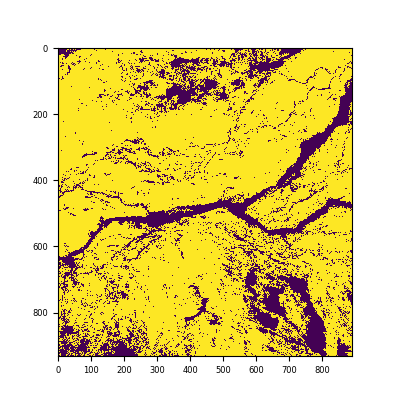

In [26]:
import ogr, gdal, osr

# Define pixel size (keep same as original) and NoData value of new raster
xres = 25 
yres = 25 
NoData_value = 0

# Filename of grassland mask shape file for current area 
vector_fn = 'fromglc10v01_-20_124_GrasslandMask_FitzSub_West.shp'

# set the geotransform properties
xcoords = smoothed.isel(time=1).vv.indexes['x'] 
ycoords = smoothed.isel(time=1).vv.indexes['y'] 
MaxValX = xcoords.shape
MaxValY = ycoords.shape
geotransform = (xcoords[MaxValX[0]-1]-(xres*0.5), xres, 0, ycoords[MaxValY[0]-1]+(yres*0.5), 0, -yres)

# Open the data source and read in the extent
source_ds = ogr.Open(vector_fn)
source_layer = source_ds.GetLayer()
source_srs = source_layer.GetSpatialRef()
vx_min, vx_max, vy_min, vy_max = source_layer.GetExtent()

# Create the destination extent
arr_aoi = smoothed.vv.isel(time =1)
arr_aoi.shape
yt,xt = arr_aoi.shape # to be the same size as SAR images

# set up mask image including projection
target_ds = gdal.GetDriverByName('MEM').Create('', xt, yt, gdal.GDT_Byte)
target_ds.SetGeoTransform(geotransform) # this is the same as the NDVI diff LL geoTIFF
latlon = osr.SpatialReference() # establish encoding
latlon.ImportFromEPSG(3577) # to projection (4326 or 3577)
target_ds.SetProjection(latlon.ExportToWkt()) # export coords to file
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(NoData_value)

# rasterise
gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])

# Read as mask array and view
Mask_array = band.ReadAsArray()

fig = plt.figure(figsize=(4,4))
plt.imshow(Mask_array)

In [27]:
# Apply grassland mask to the RVI, Entropy

smoothed_grassland = smoothed.where(np.flip(Mask_array==1))
dp_grassland = dp.where(np.flip(Mask_array==1))

<IPython.core.display.Javascript object>


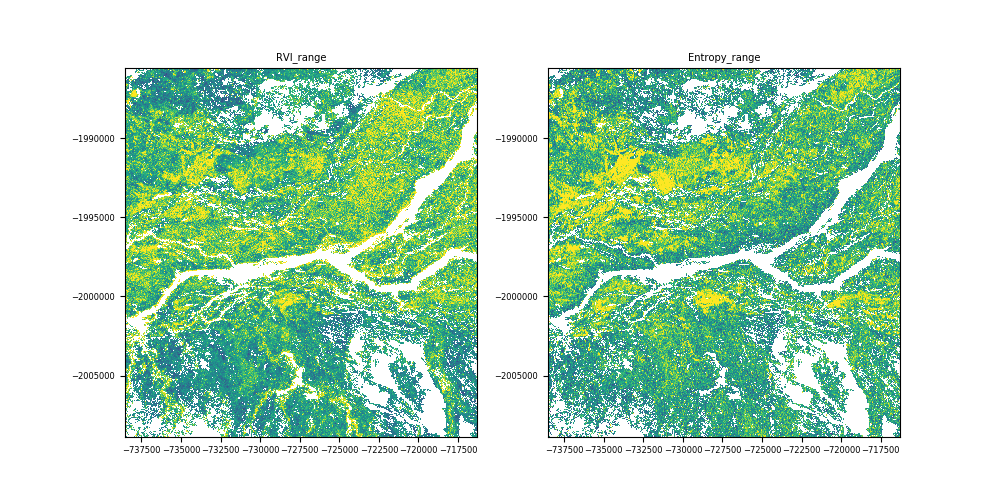

Text(0.5, 1.0, 'Entropy_range')

In [28]:
# View the RVI, Entropy annual range

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(np.flip(smoothed_grassland.RVI_range), clim=(0,1.2), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()])
ax[1].imshow(np.flip(dp_grassland.entropy_range), clim=(0.2,0.6), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()])

ax[0].set_title('RVI_range')
ax[1].set_title('Entropy_range')

# 9. Generate monthly means for RVI and Entropy

In [29]:
# Generate RVI monthly mean for current year

import pandas as pd
time = pd.to_datetime([Year+'-01-01',Year+'-02-01',Year+'-03-01',Year+'-04-01',Year+'-05-01',Year+'-06-01',
                             Year+'-07-01',Year+'-08-01',Year+'-09-01',Year+'-10-01',Year+'-11-01',Year+'-12-01'])

monthly_mean_RVI=xr.Dataset({'Jan':(smoothed_grassland.RVI.sel(time=slice(Year+'-01-01', Year+'-01-31')).mean(dim='time')), 'time': time})
monthly_mean_RVI['Feb']=smoothed_grassland.RVI.sel(time=slice(Year+'-02-01', Year+'-02-28')).mean(dim='time')
monthly_mean_RVI['Mar']=smoothed_grassland.RVI.sel(time=slice(Year+'-03-01', Year+'-03-31')).mean(dim='time')
monthly_mean_RVI['Apr']=smoothed_grassland.RVI.sel(time=slice(Year+'-04-01', Year+'-04-30')).mean(dim='time')
monthly_mean_RVI['May']=smoothed_grassland.RVI.sel(time=slice(Year+'-05-01', Year+'-05-31')).mean(dim='time')
monthly_mean_RVI['Jun']=smoothed_grassland.RVI.sel(time=slice(Year+'-06-01', Year+'-06-30')).mean(dim='time')
monthly_mean_RVI['Jul']=smoothed_grassland.RVI.sel(time=slice(Year+'-07-01', Year+'-07-31')).mean(dim='time')
monthly_mean_RVI['Aug']=smoothed_grassland.RVI.sel(time=slice(Year+'-08-01', Year+'-08-31')).mean(dim='time')
monthly_mean_RVI['Sep']=smoothed_grassland.RVI.sel(time=slice(Year+'-09-01', Year+'-09-30')).mean(dim='time')
monthly_mean_RVI['Oct']=smoothed_grassland.RVI.sel(time=slice(Year+'-10-01', Year+'-10-31')).mean(dim='time')
monthly_mean_RVI['Nov']=smoothed_grassland.RVI.sel(time=slice(Year+'-11-01', Year+'-11-30')).mean(dim='time')
monthly_mean_RVI['Dec']=smoothed_grassland.RVI.sel(time=slice(Year+'-12-01', Year+'-12-31')).mean(dim='time')

monthly_mean_RVI = monthly_mean_RVI.assign_attrs(bs_attrs)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<IPython.core.display.Javascript object>


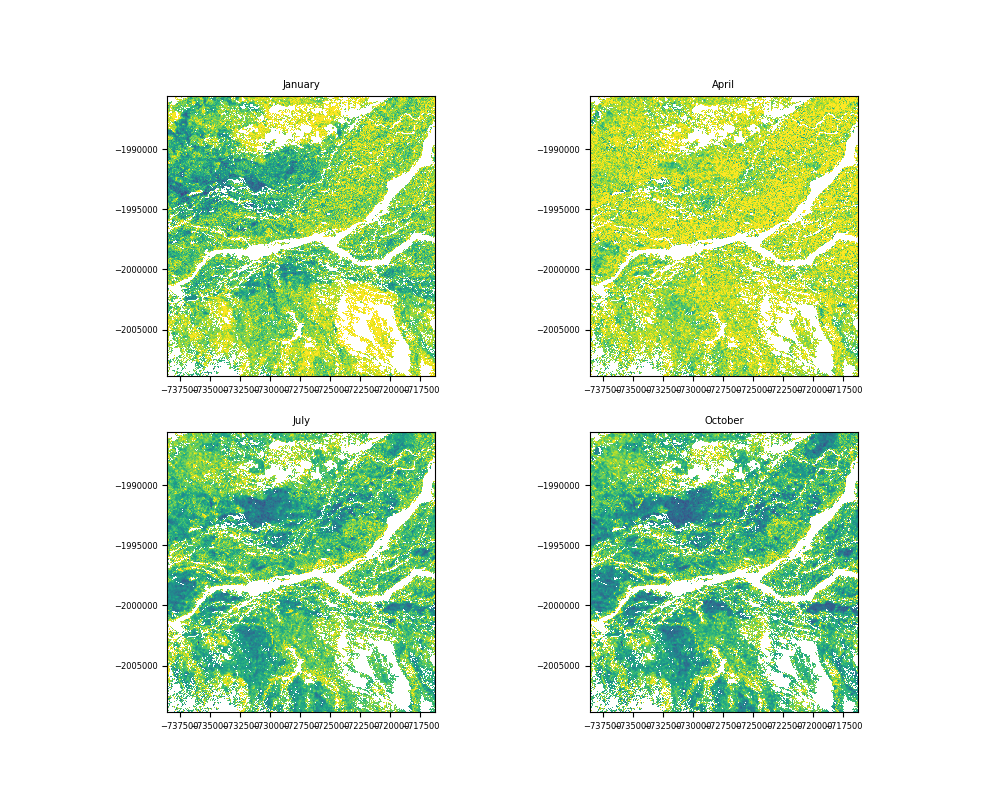

Text(0.5, 1.0, 'October')

In [30]:
# View some of the RVI monthly means

fig, ax = plt.subplots(2,2, figsize=(10,8))
ax[0,0].imshow(np.flip(monthly_mean_RVI.Jan), clim=(0.0,1.0), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()])
ax[0,1].imshow(np.flip(monthly_mean_RVI.Apr), clim=(0.0,1.0), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()])
ax[1,0].imshow(np.flip(monthly_mean_RVI.Jul), clim=(0.0,1.0), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()])
ax[1,1].imshow(np.flip(monthly_mean_RVI.Oct), clim=(0.0,1.0), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()])

ax[0,0].set_title('January')
ax[0,1].set_title('April')
ax[1,0].set_title('July')
ax[1,1].set_title('October')

In [31]:
# Generate Entropy monthly mean for current year

import pandas as pd
time = pd.to_datetime([Year+'-01-01',Year+'-02-01',Year+'-03-01',Year+'-04-01',Year+'-05-01',Year+'-06-01',
                             Year+'-07-01',Year+'-08-01',Year+'-09-01',Year+'-10-01',Year+'-11-01',Year+'-12-01'])

monthly_mean_entropy=xr.Dataset({'Jan':(dp_grassland.entropy.sel(time=slice(Year+'-01-01', Year+'-01-31')).mean(dim='time')), 'time': time})
monthly_mean_entropy['Feb']=dp_grassland.entropy.sel(time=slice(Year+'-02-01', Year+'-02-28')).mean(dim='time')
monthly_mean_entropy['Mar']=dp_grassland.entropy.sel(time=slice(Year+'-03-01', Year+'-03-31')).mean(dim='time')
monthly_mean_entropy['Apr']=dp_grassland.entropy.sel(time=slice(Year+'-04-01', Year+'-04-30')).mean(dim='time')
monthly_mean_entropy['May']=dp_grassland.entropy.sel(time=slice(Year+'-05-01', Year+'-05-31')).mean(dim='time')
monthly_mean_entropy['Jun']=dp_grassland.entropy.sel(time=slice(Year+'-06-01', Year+'-06-30')).mean(dim='time')
monthly_mean_entropy['Jul']=dp_grassland.entropy.sel(time=slice(Year+'-07-01', Year+'-07-31')).mean(dim='time')
monthly_mean_entropy['Aug']=dp_grassland.entropy.sel(time=slice(Year+'-08-01', Year+'-08-31')).mean(dim='time')
monthly_mean_entropy['Sep']=dp_grassland.entropy.sel(time=slice(Year+'-09-01', Year+'-09-30')).mean(dim='time')
monthly_mean_entropy['Oct']=dp_grassland.entropy.sel(time=slice(Year+'-10-01', Year+'-10-31')).mean(dim='time')
monthly_mean_entropy['Nov']=dp_grassland.entropy.sel(time=slice(Year+'-11-01', Year+'-11-30')).mean(dim='time')
monthly_mean_entropy['Dec']=dp_grassland.entropy.sel(time=slice(Year+'-12-01', Year+'-12-31')).mean(dim='time')

monthly_mean_entropy = monthly_mean_entropy.assign_attrs(bs_attrs)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<IPython.core.display.Javascript object>


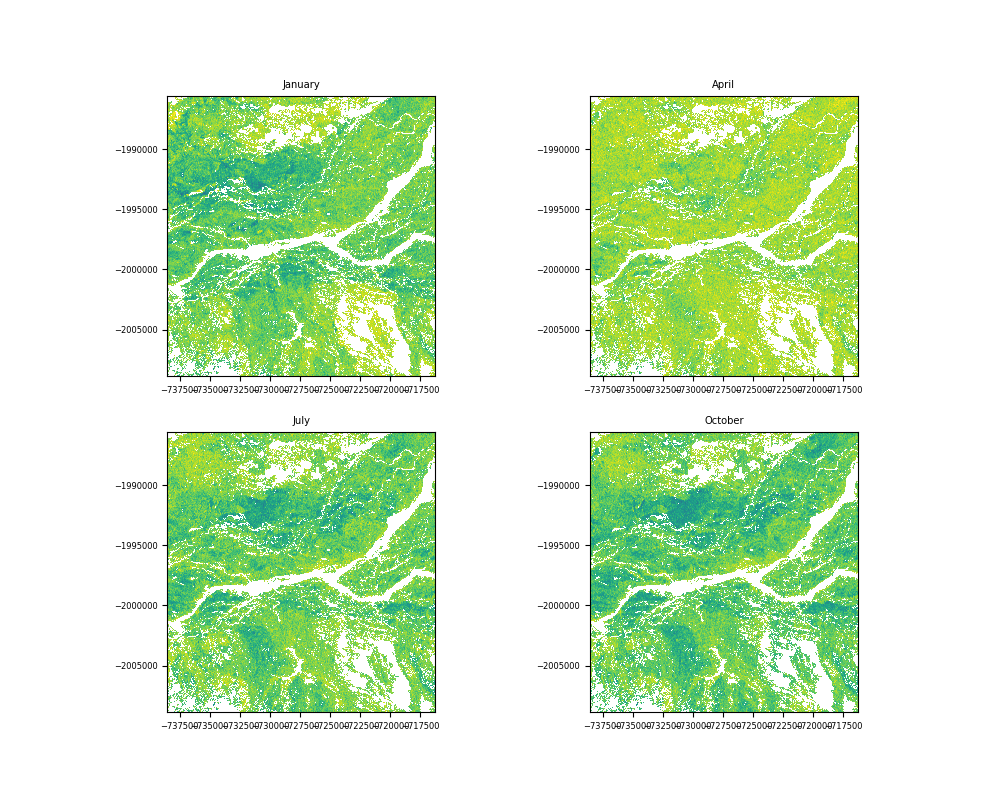

Text(0.5, 1.0, 'October')

In [32]:
# View some of the Entropy monthly means

fig, ax = plt.subplots(2,2, figsize=(10,8))
ax[0,0].imshow(np.flip(monthly_mean_entropy.Jan), clim=(0.0,0.9), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()])
ax[0,1].imshow(np.flip(monthly_mean_entropy.Apr), clim=(0.0,0.9), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()])
ax[1,0].imshow(np.flip(monthly_mean_entropy.Jul), clim=(0.0,0.9), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()])
ax[1,1].imshow(np.flip(monthly_mean_entropy.Oct), clim=(0.0,0.9), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()])

ax[0,0].set_title('January')
ax[0,1].set_title('April')
ax[1,0].set_title('July')
ax[1,1].set_title('October')

# 10. Save results to GeoTIFFs
RVI and Entropy monthly means and annual range are saved to 'out_dir'

In [33]:
# write output images (in Albers) to GeoTIFF

import ogr, gdal, osr

# define coordinates for Albers equal area (3577)
xcoords = smoothed_grassland.isel(time=1).vv.indexes['x']
ycoords = smoothed_grassland.isel(time=1).vv.indexes['y']
yt,xt = smoothed_grassland.isel(time=1).vv.shape
MaxValX = xcoords.shape
MaxValY = ycoords.shape

# set geotransform and output projection
xres = 25 
yres = 25 
geotransform = (xcoords[MaxValX[0]-1]-(xres*0.5), xres, 0, ycoords[MaxValY[0]-1]+(yres*0.5), 0, -yres) # offset by half the pixel size since it needs to be top-left pixel coord
srs = osr.SpatialReference() 
srs.ImportFromEPSG(3577)

# loop through monthly images
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Edit output filenames (filename_RVI and filename_entropy) and directory as required
for month in months:
    
    filename_RVI = 'S1_RVI_Grasslands_3577_'+ month +'_'+ Year +'.tif' 
    S1_ds = gdal.GetDriverByName('GTiff').Create(filename_RVI, xt, yt, 1, gdal.GDT_Float32)
    S1_ds.SetGeoTransform(geotransform) # specify coordinates
    S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
    S1_ds.GetRasterBand(1).WriteArray(np.flip(monthly_mean_RVI[month]).data) # write band to raster
    S1_ds.FlushCache()  # write to file
    S1_ds = None # save and close
    
    filename_entropy = 'S1_Entropy_Grasslands_3577_'+ month + '_'+ Year + '.tif' 
    S1_ds = gdal.GetDriverByName('GTiff').Create(filename_entropy, xt, yt, 1, gdal.GDT_Float32)
    S1_ds.SetGeoTransform(geotransform) # specify coordinates
    S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
    S1_ds.GetRasterBand(1).WriteArray(np.flip(monthly_mean_entropy[month]).data) # write band to raster
    S1_ds.FlushCache()  # write to file
    S1_ds = None # save and close
    
# Output annual RVI and Entropy range images
filename_RVI = 'S1_RVI_Grasslands_3577_Annual_Range_' + Year +'.tif' 
S1_ds = gdal.GetDriverByName('GTiff').Create(filename_RVI, xt, yt, 1, gdal.GDT_Float32)
S1_ds.SetGeoTransform(geotransform) # specify coordinates
S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
S1_ds.GetRasterBand(1).WriteArray(np.flip(smoothed_grassland.RVI_range).data) # write band to raster
S1_ds.FlushCache()  # write to file
S1_ds = None # save and close

# Output annual RVI and Entropy range images
filename_entropy = 'S1_Entropy_Grasslands_3577_Annual_Range_' + Year + '.tif' 
S1_ds = gdal.GetDriverByName('GTiff').Create(filename_entropy, xt, yt, 1, gdal.GDT_Float32)
S1_ds.SetGeoTransform(geotransform) # specify coordinates
S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
S1_ds.GetRasterBand(1).WriteArray(np.flip(dp_grassland.entropy_range).data) # write band to raster
S1_ds.FlushCache()  # write to file
S1_ds = None # save and close